<a href="https://colab.research.google.com/github/PAastha/Sentiment-Analysis-using-RNN-StackedLSTM/blob/main/Sentiment_Analysis_using_tensorflow%2CRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam



In [4]:
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import re
import os
import warnings
warnings.filterwarnings("ignore")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
file_path = '/content/drive/My Drive/Sentiment/training.1600000.processed.noemoticon.csv'
data = pd.read_csv(file_path,encoding='latin',header=None)


EXPLORATORY DATA ANALYSIS

In [8]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
#Renaming  columns names
#Because of the numerical columns names,it will be more convinient to work with a dataset with predefined columns names

data=data.rename(columns={0:'target',1:'id',2:'date',3:'query',4:'username',5:'content'})

Now columns are more informative with respective to their names


Missing values


Missing data is common occurance in datasets, therefore it is recommended to check if a data set contains missing values before starting any analysis.

In [11]:
missing_data = data.isna().sum().sort_values(ascending=False)
percentage_missing = round((data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
missing_info.style.background_gradient()

,Missing values,Percentage
target,0,0.000000
id,0,0.000000
date,0,0.000000
query,0,0.000000
username,0,0.000000
content,0,0.000000


Lets understand the contextual part of the target column, first find the unique values in this column, understand the notion and rename them

In [12]:
data['target'].unique()

array([0, 4])

In [13]:

data[data['target']==0]['content'].head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: content, dtype: object

By reading the content of the tweets, we can conclude that they have a rather negative message, so class 0 refers to negative sentiments tweets.

In [14]:
data[data['target']==4]['content'].head()

800000         I LOVE @Health4UandPets u guys r the best!! 
800001    im meeting up with one of my besties tonight! ...
800002    @DaRealSunisaKim Thanks for the Twitter add, S...
800003    Being sick can be really cheap when it hurts t...
800004      @LovesBrooklyn2 he has that effect on everyone 
Name: content, dtype: object

By reading the content of the tweets, we can conclude that they have a rather positive message, so class 4 refers to positive sentiments tweets.

In [15]:
data['target'] = data['target'].replace([0, 4],['Negative','Positive'])

Changing labels from 0 and 4 for more informative labels for further analysis

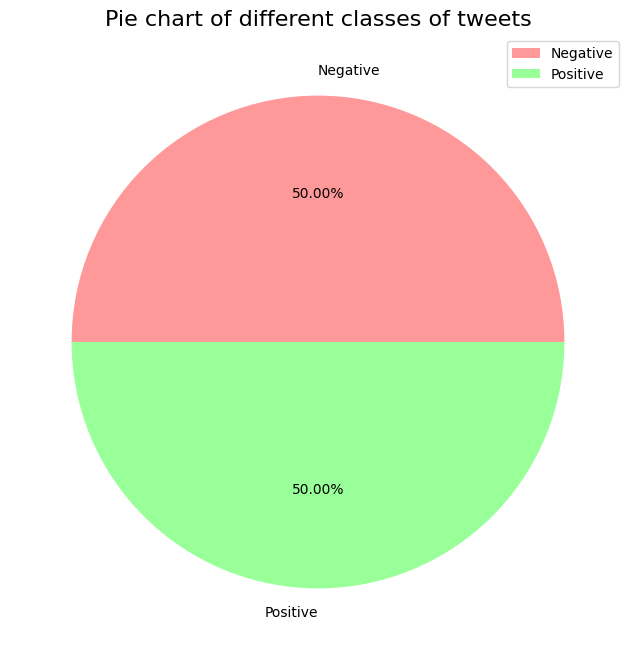

In [16]:

light_tone_colors = ['#FF9999', '#99FF99']

fig = plt.figure(figsize=(8, 8))
targets = data.groupby('target').size()
targets.plot(kind='pie', subplots=True, figsize=(10, 8), autopct="%.2f%%", colors=light_tone_colors)
plt.title("Pie chart of different classes of tweets", fontsize=16)
plt.legend()
plt.show()

In [17]:
data['target'].value_counts()

Negative    800000
Positive    800000
Name: target, dtype: int64

As we can see dataset is perfectly balanced with the same numbers of occurrences for both classes. It is also worth mentioning that the data is not skewed which will certainly make modeling easier.

Length of tweets according to the target lables

We can vizulaize based on the target class, how long the tweets generally are taken

In [18]:
data['length']=data['content'].str.split().apply(len)


Adding new column to dataset with length of particular tweets.

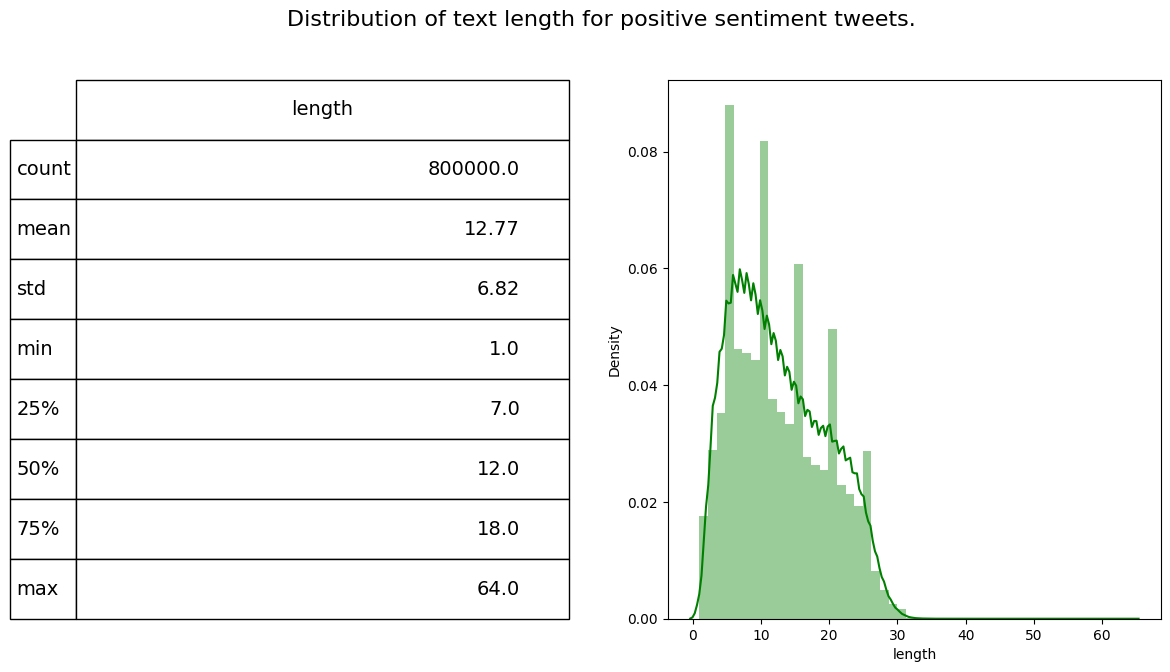

In [19]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='Positive']['length'], ax=ax1,color='green')
describe = data.length[data.target=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()


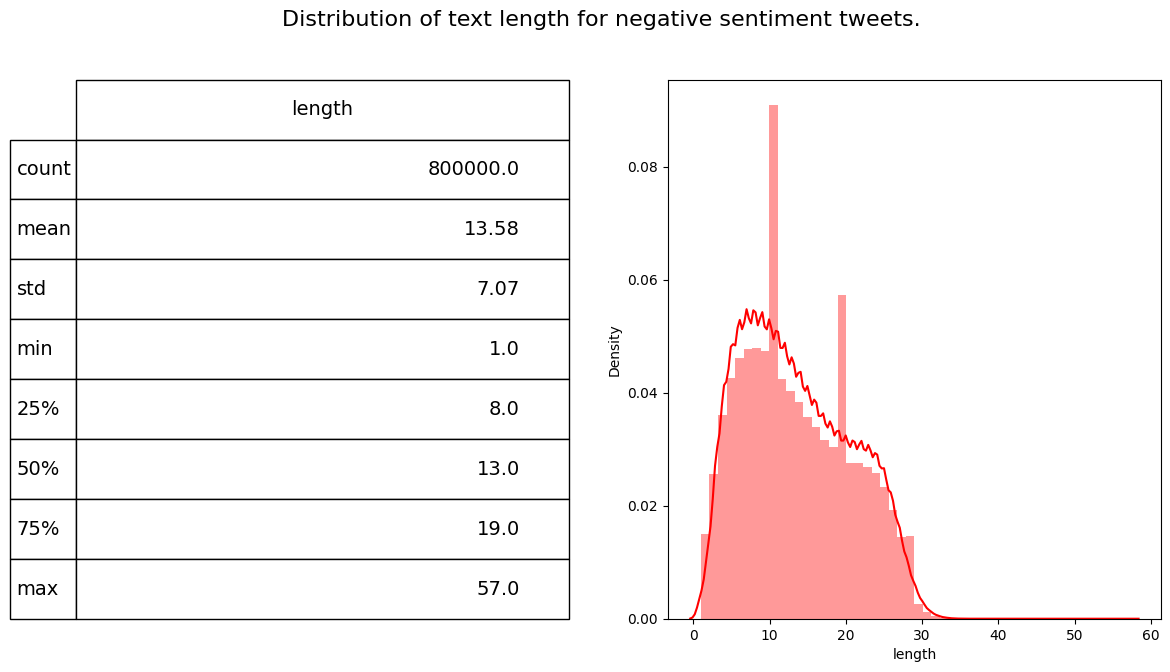

In [20]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='Negative']['length'], ax=ax1,color='red')
describe = data.length[data.target=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

In such a large dataset, tweets belonging to two classes are almost the same lengths. However, the average tweet length for the negative class is about 0.8 words longer.

**Most commonly tweeting users**

In [21]:
x=data[data['target']=='Positive']['username'].value_counts()
print(x)

what_bugs_u       246
DarkPiano         231
VioletsCRUK       218
tsarnick          212
keza34            211
                 ... 
southernbelle2      1
PKJMG               1
aworthlessdrug      1
RoOcKz              1
bpbabe              1
Name: username, Length: 376569, dtype: int64


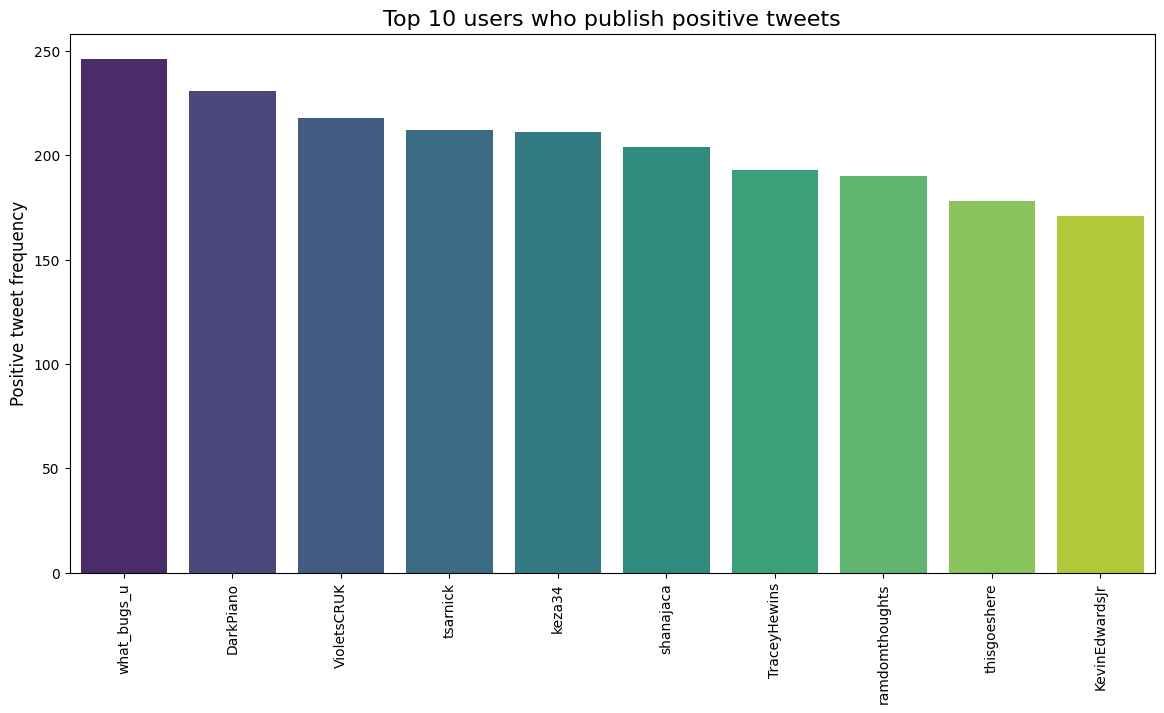

In [22]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='Positive']['username'].value_counts()[:10].index, \
                           y=data[data['target']=='Positive']['username'].value_counts()[:10],palette='viridis')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Positive tweet frequency',fontsize=12)
plt.title('Top 10 users who publish positive tweets',fontsize=16)
plt.show()

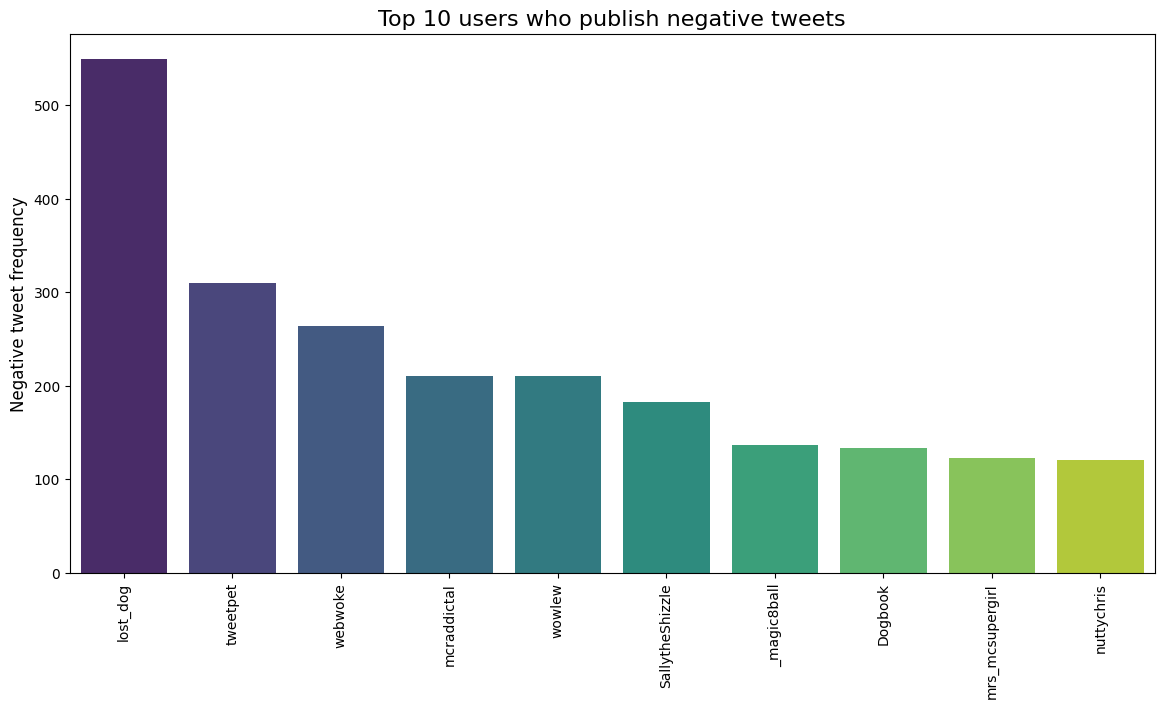

In [23]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='Negative']['username'].value_counts()[:10].index, \
                           y=data[data['target']=='Negative']['username'].value_counts()[:10],palette='viridis')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Negative tweet frequency',fontsize=12)
plt.title('Top 10 users who publish negative tweets',fontsize=16)
plt.show()

In [24]:
data[data['username']=='what_bugs_u'].head()

,target,id,date,query,username,content,length
1141441,Positive,1977182027,Sat May 30 20:18:46 PDT 2009,NO_QUERY,what_bugs_u,@JadeMcCray why limit your story to 140 chr. T...,22
1141626,Positive,1977198277,Sat May 30 20:21:22 PDT 2009,NO_QUERY,what_bugs_u,@cadmiumcannibal why limit your story to 140 c...,22
1141648,Positive,1977207353,Sat May 30 20:22:52 PDT 2009,NO_QUERY,what_bugs_u,@RonanDosSantos why limit your story to 140 ch...,22
1141674,Positive,1977208245,Sat May 30 20:23:01 PDT 2009,NO_QUERY,what_bugs_u,@ShayMac28 why limit your story to 140 chr. Te...,22
1142667,Positive,1977331498,Sat May 30 20:43:12 PDT 2009,NO_QUERY,what_bugs_u,@lynnsdecor why limit your story to 140 chr. T...,22


Based on the contet posted by the user, it can be concluded that this is not a regular user but it is just a bot.



In [25]:
data[data['username']=='lost_dog'].head()


,target,id,date,query,username,content,length
43935,Negative,1676704158,Fri May 01 22:54:02 PDT 2009,NO_QUERY,lost_dog,@NyleW I am lost. Please help me find a good h...,11
45574,Negative,1677189389,Sat May 02 00:51:35 PDT 2009,NO_QUERY,lost_dog,@SallyD I am lost. Please help me find a good ...,11
46919,Negative,1677519173,Sat May 02 02:30:50 PDT 2009,NO_QUERY,lost_dog,@zuppaholic I am lost. Please help me find a g...,11
47949,Negative,1677752995,Sat May 02 03:47:51 PDT 2009,NO_QUERY,lost_dog,@LOSTPETUSA I am lost. Please help me find a g...,11
50572,Negative,1678544903,Sat May 02 07:02:28 PDT 2009,NO_QUERY,lost_dog,@JeanLevertHood I am lost. Please help me find...,11


It seems that lost dog bots are rather in a bad mood.

**Wordclouds**

By creating word clouds for two classes, we can visualize what words were repeated most often for positive and negative classes. We don't want to show stopwords so i took base of stopwords from nltk library and i passed it to WordCloud function

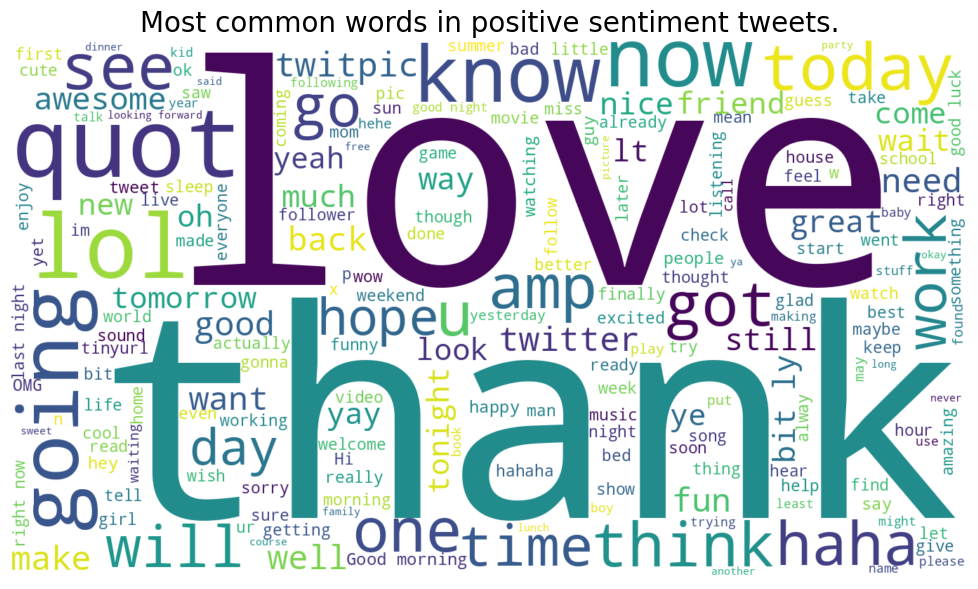

In [26]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Positive'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in positive sentiment tweets.',fontsize=20)
plt.show()

Based on the word cloud, it can be deduced that the most repeated words in tweets with positive sentiment are words such as: love, quot, lol, haha, thank, today.

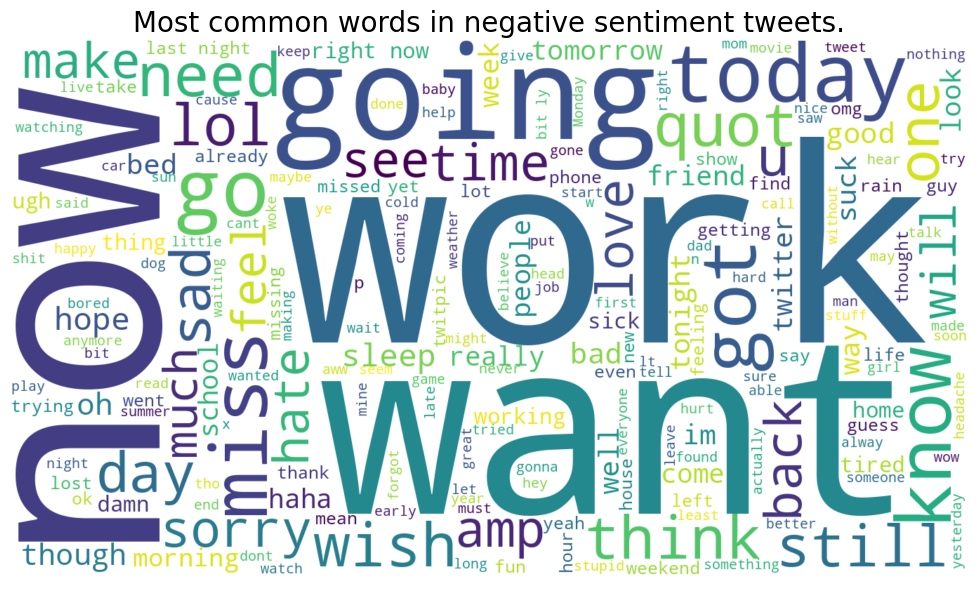

In [27]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Negative'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in negative sentiment tweets.',fontsize=20)
plt.show()

Based on the word cloud, it can be deduced that the most repeated words in tweets with negative sentiment are words such as: quot, lol, today which are the same as for positive sentiment class. However, there are also word occurrences from which negative sentiment of a tweet can be inferred such as: miss, sorry, hate etc.

**DATA PREPARING**

**Dropping unnecessary columns**

There are a lot of unnecessary columns in the following dataset. The task is to classify the semantics of a tweet, so all columns except the target and content columns are unnecessary.

In [28]:
data.drop(['id','date','query','username','length'], axis=1, inplace=True)

In [29]:
data.head()


,target,content
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [30]:
#Replacing Positive and Negative labels with 1 and 0 respectively.
data.target = data.target.replace({'Positive': 1, 'Negative': 0})

**Content cleaning**

Stemming - it does refers to the process which goal is to reduce words into thier base form. In case of our problem for classification it is very important ooperation as we need to focus on the meaning of particular word. For instance words: Running, Runned, Runner all can reduce to the stem Run. Below we have used the base of english stopwords and stemming algorithm from nltk library.

In [31]:
#base of english stopwords
english_stopwords=stopwords.words('english')
#stemming algorithm
stemmer=SnowballStemmer('english')
#regex for mentions and links in tweets
regex="@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [32]:
def preprocess(content, stem=False):
  content = re.sub(regex, ' ', str(content).lower()).strip()
  tokens = []
  for token in content.split():
    if token not in english_stopwords:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)

In [33]:
data['content']=data['content'].apply(lambda x: preprocess(x))

In [34]:
data.head()

,target,content
0,0,awww bummer shoulda got david carr third day
1,0,upset updat facebook text might cri result sch...
2,0,dive mani time ball manag save 50 rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav mad see


**Train test split**
Due to the rather large size of the dataset 160000 tweets will be enough for testing

In [35]:
train, test = train_test_split(data, test_size=0.1, random_state=44)

In [36]:
print('Train dataset shape: {}'.format(train.shape))
print('Test dataset shape: {}'.format(test.shape))

Train dataset shape: (1440000, 2)
Test dataset shape: (160000, 2)


**Tokenization**

It is a particular kind of document segmentation. It does breaks up text into smaller chunks or segments called tokens. A tokenizer breaks unstructured data, natural language text, into chunks of information that can be counted as discrete elements. After this operation these counts of token occurences in particular document can be used as a vector representing given document

In [37]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(train['content'])
vocab_size= len(tokenizer.word_index) + 1
max_length=50

Based on the analysis of the tweet length it was concluded that the maximum length for tokenization equal to 50 will be sufficient

In [38]:
sequences_train = tokenizer.texts_to_sequences(train.content)
sequences_test = tokenizer.texts_to_sequences(test.content)

X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = train.target.values
y_test = test.target.values


**Word embeddings using GloVe**

Word embeddings provide a dense representation of words and their relative meanings. Embedding Matrix is a maxtrix of all words and their corresponding embeddings. Embedding matrix is used in embedding layer in model to embedded a token into it's vector representation, that contains information regarding that token or word.

Embedding vocabulary is taken from the tokenizer and the corresponding vectors from embedding model, which in this case is GloVe model. GloVe stand for Global Vectors for Word Representation and it is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Below was used pretrained GloVe embeddings from world known Stanford vector files. The smallest available file contains embeddings created for tiny 6 billions of tokens.


In [39]:
file_path2 = '/content/drive/My Drive/Sentiment/glove.6B.100d.txt'

In [40]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open(file_path2)

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

**Model test harness**


The proposed model architecture will be tested on the following parameters:

loss = "binnary_crossentropy" (due to binary classification problem)

optimizer = Adam(learning_rate=0.001) (may be changed after seeing the learning graph)

metrics = "accuracy" (due to binary classification problem)

number of epochs = 10 (due to the large training data set)

batch size = 1000 (in order to accelerate learning time)

In [41]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)

In [42]:
num_epochs = 2
batch_size = 200

**Model - Embedding + Stacked LSTM**


Model consisted of layers build with lstm cells. With such a large amount of data, the model is computationally complex making the training process take a while. Furthermore, model regularization layers will reduce the possible overfitting which was present in the simpler models tested.

In [43]:
model = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(64)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           26901500  
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4

In [45]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [46]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)

Epoch 1/2
7200/7200 - 3855s - loss: 0.5224 - accuracy: 0.7361 - val_loss: 0.5033 - val_accuracy: 0.7517 - 3855s/epoch - 535ms/step
Epoch 2/2
7200/7200 - 3873s - loss: 0.4953 - accuracy: 0.7561 - val_loss: 0.4949 - val_accuracy: 0.7558 - 3873s/epoch - 538ms/step


In [47]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

5000/5000 [==============================] - 215s 43ms/step


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76     79800
           1       0.76      0.75      0.76     80200

    accuracy                           0.76    160000
   macro avg       0.76      0.76      0.76    160000
weighted avg       0.76      0.76      0.76    160000



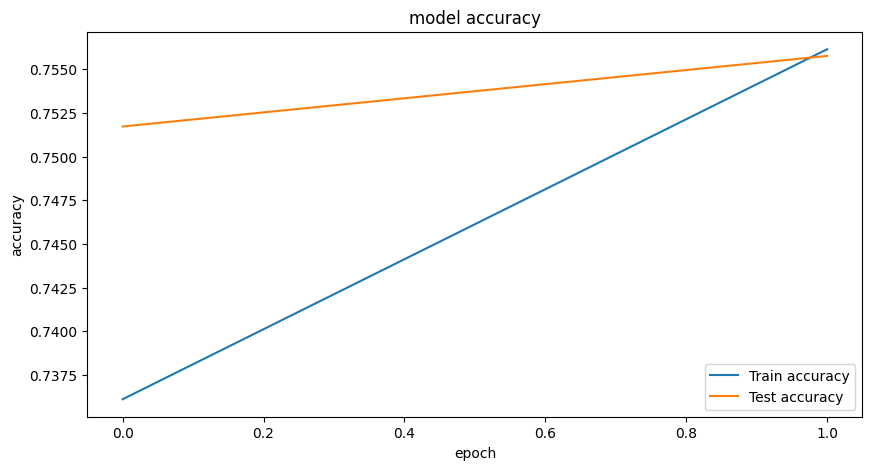

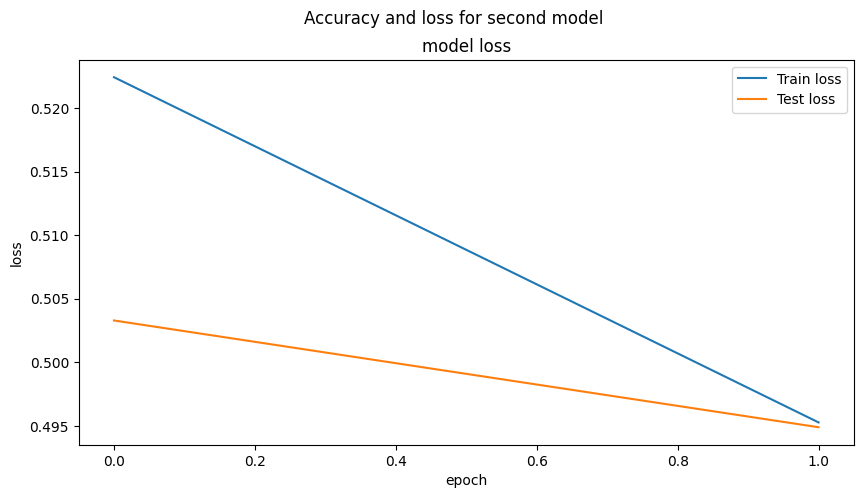

In [49]:
#History for accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
# History for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.suptitle('Accuracy and loss for second model')
plt.show()

**Conclusions**

Presented model performed quite good but there is also visible overfitting, learning rate increase or other hyperparameter tuning should help
Larger dropout layers also could help with overfitting.

Another improvement might be to use a more complex embedding layer.

High accuracy was not achieved for the training data which may indicate an unrepresentative training dataset.